In [1]:
import os
import keras
import mne
import numpy as np
import pandas as pd
import scipy.io
import tensorflow as tf
from mne.channels import make_standard_montage
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


In [2]:
def annotations_from_eGUI(raw, egui):
    """
    function to create mne annotations for a mne.Raw object from a time series
    containing the state of the display
    """

    codes = []
    starts = []
    current_state = None

    for i in range(len(egui)):
        if egui[i][0] != current_state:
            starts.append(i)
            current_state = egui[i][0]
            codes.append(str(egui[i][0]))

    starts.append(len(egui))
    codes = np.array(codes)
    sf = raw.info.get("sfreq")
    starts = np.array(starts) / sf
    durations = starts[1:] - starts[:-1]
    starts = starts[:-1]

    raw.set_annotations(
        mne.Annotations(onset=starts, duration=durations, description=codes)
    )


def raw_from_mat(file):
    """function to load data from a .mat file into a mne.Raw object"""
    mat = scipy.io.loadmat(os.path.join(data_dir, file))

    sampling_freq = mat["o"][0][0][2][0][0]
    n_samples = mat["o"][0][0][3][0][0]
    ch_names = [element[0][0] for element in mat["o"][0][0][6]]

    df = pd.DataFrame(mat["o"][0][0][5], columns=ch_names)
    df = df.drop(columns=["X5"])  # unsupported channel
    df = df.T
    ch_names.remove("X5")

    ch_types = ["eeg"] * 21
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    raw = mne.io.RawArray(df.to_numpy(), info)

    montage = make_standard_montage("standard_prefixed")
    raw.set_montage(montage)

    raw.load_data().set_eeg_reference(ref_channels="average")
    annotations_from_eGUI(raw, mat["o"][0][0][4])
    return raw


def filter_raw(raw):
    return raw.load_data().filter(0.1, 30, method="fir", phase="zero-double")


def get_epochs(raw, event_id):
    """function to extract mne epochs from a mne.Raw object"""
    metadata_tmin, metadata_tmax = -1, 1
    all_events, all_event_id = mne.events_from_annotations(
        raw,
        event_id=event_id,
    )
    metadata, events, event_id = mne.epochs.make_metadata(
        events=all_events,
        event_id=event_id,
        tmin=metadata_tmin,
        tmax=metadata_tmax,
        sfreq=raw.info["sfreq"],
    )
    print(raw.info["sfreq"])
    return mne.Epochs(raw, events, event_id, tmin=-1.0, tmax=1.0, baseline=(-1, 1))


# Data Loading and Preparation

We will create now several Datasets on which  we will test our methods.

 - `epochs_NoMT` will correspond to the data which is our baseline and where the subject is in a resting position whith no input on the screen. ( only take events "0")
 - `epochs_NOMT_only_code_2` will correspond to the data which comes from the same trails and session of the epochs_NoMT data, but here we select epochs where something is shown on the screen. (only take events "2")
 - `epochs_FREEFORM` will correspond to the data which comes from a diffrent session and here the subject can voluntarily  press buttons (either left or right)

In [3]:
# set up paths of data
data_dir = os.path.dirname("./data/")
data_files = os.listdir(data_dir)


In [4]:
# load data to raw objects
raw_NoMT = [raw_from_mat(file) for file in data_files if "NoMT" in file]
raw_FREEFORM = [raw_from_mat(file) for file in data_files if "FREEFORM" in file]


Creating RawArray with float64 data, n_channels=21, n_times=664400
    Range : 0 ... 664399 =      0.000 ...  3321.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=664600
    Range : 0 ... 664599 =      0.000 ...  3322.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=662400
    Range : 0 ... 662399 =      0.000 ...  3311.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 d

In [5]:
# epoch data
epochs_NoMT = [get_epochs(file, {"0": 1}) for file in raw_NoMT]
epochs_FREEFORM = [get_epochs(file, {"1": 2, "2": 3}) for file in raw_FREEFORM]
epochs_NOMT_only_code_2 = [get_epochs(file, {"2": 3}) for file in raw_NoMT]


Used Annotations descriptions: ['0']
200.0
Not setting metadata
966 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
960 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
963 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0

In [6]:
# put data in arrays
epochs_data_NOMT = [file.get_data() for file in epochs_NoMT]
epochs_data_FREEFORM = [file.get_data() for file in epochs_FREEFORM]
epochs_Data_NOMT_2 = [file.get_data() for file in epochs_NOMT_only_code_2]

X_NOMT = np.vstack(epochs_data_NOMT)
X_free = np.vstack(epochs_data_FREEFORM)
X_nomt_2 = np.vstack(epochs_Data_NOMT_2)

np.random.shuffle(X_NOMT)
np.random.shuffle(X_free)
np.random.shuffle(X_nomt_2)

print(X_NOMT.shape)
print(X_free.shape)
print(X_nomt_2.shape)


Using data from preloaded Raw for 966 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 960 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 963 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 967 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 739 events and 401 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 688 events and 401 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 700 events and 401 original time points ...
0 bad epochs dropped
Using data

# Data Preprocessing

In [7]:
# split train data from nomt data
N = X_NOMT.shape[0]
X_NOMT = np.moveaxis(X_NOMT, 1, 2)
X_free = np.moveaxis(X_free, 1, 2)
X_nomt_2 = np.moveaxis(X_nomt_2, 1, 2)

X_nomt_train = X_NOMT[:5000]
X_nomt_test = X_NOMT[5000:]


In [8]:
print(X_nomt_train.shape)
print(X_nomt_test.shape)
print(X_free.shape)
print(X_nomt_2.shape)


(5000, 401, 21)
(1753, 401, 21)
(2127, 401, 21)
(1114, 401, 21)


In [9]:
# normalise data
norm_X_NOMT = layers.Normalization()
norm_X_free = layers.Normalization()
norm_X_nomt_2 = layers.Normalization()

norm_X_NOMT.adapt(X_NOMT.astype(float))
norm_X_free.adapt(X_free.astype(float))
norm_X_nomt_2.adapt(X_nomt_2.astype(float))

scaled_X_nomt_train = norm_X_NOMT(X_nomt_train)
scaled_X_nomt_test = norm_X_NOMT(X_nomt_test)
scaled_X_free = norm_X_free(X_free)
scaled_X_nomt_2 = norm_X_nomt_2(X_nomt_2)


# Helper functions

In [10]:
def calc_reconstruction_error(ae, A, B, pr=True):
    err = []
    err2 = []
    for i in A:
        # need to expand here because the flatten layer assumes that the first dimension is the number of samples
        i = np.expand_dims(i, axis=0)
        err.append((np.square(i - ae.call(i))).mean())
    print("###################")

    for j in B:
        j = np.expand_dims(j, axis=0)
        err2.append((np.square(j - ae.call(j))).mean())
    if pr:
        print("Mean reconstruction errors : ")
        print(np.array(err).mean())
        print(np.array(err2).mean())
    return err, err2


In [11]:
def calc_accuracy(model, A, B, th):
    """function to compute the accuracy of event classification by thresholding the reconstruction error"""
    a, b = calc_reconstruction_error(model, A, B, pr=False)
    first = [1 if i < th else 0 for i in a]
    last = [1 if i > th else 0 for i in b]
    last2 = [0 if i > th else 1 for i in b]
    return sum(np.concatenate((first, last))) / len(
        np.concatenate((first, last))
    ), np.concatenate((first, last2))


In [12]:
def train_model(ae, X_train, X_test, lr, epochs, bs):
    hist = ae.fit(
        X_train,
        X_train,
        epochs=epochs,
        batch_size=bs,
        shuffle=True,
        validation_data=(X_test, X_test),
    )

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()
    return (
        hist.history["loss"],
        hist.history["val_loss"],
        lr.learning_rate.numpy(),
        epochs,
        bs,
    )


In [13]:
def print_and_calc_results(model, A, A_title, B, B_title, scale=True):
    ar1, ar2 = calc_reconstruction_error(model, A, B, pr=False)
    print("Reconstruction Error of :")
    print(A_title)
    print("Mean")
    print(np.mean(ar1))
    print("Median")
    print(np.median(ar1))
    print("Reconstruction Error of :")
    print(B_title)
    print("Mean")
    print(np.mean(ar2))
    print("Median")
    print(np.median(ar2))

    if scale:
        _ = plt.hist(ar1, bins=100, range=(0, 2), label=A_title)
        _ = plt.hist(ar2, bins=100, range=(0, 2), label=B_title)
        plt.title("Histogram of Reconstruction error")
        plt.xlim((0, 2))
        plt.legend()
        plt.xlabel("reconstruction error")
        plt.ylabel("frequency")
        plt.show()
    else:
        _ = plt.hist(ar1, bins=200, range=(0, 500), label=A_title)
        _ = plt.hist(ar2, bins=200, range=(0, 500), label=B_title)
        plt.title("Histogram of Reconstruction error")
        plt.xlabel("reconstruction error")
        plt.ylabel("frequency")
        plt.legend()
        plt.show()


In [14]:
def acc_over_n_runs(ae, A, B, th, n):
    A = A.numpy()
    B = B.numpy()
    erg = []
    for i in np.arange(n):
        np.take(A, np.random.permutation(A.shape[0]), axis=0, out=A)
        np.take(B, np.random.permutation(B.shape[0]), axis=0, out=B)
        acc, _ = calc_accuracy(ae, A[:500], B[:500], th)
        erg.append(acc)
    print(erg)
    print(f"Final acc over {n} runs:", np.mean(erg))


# Convolutional Autoencoder

In [15]:
keras.backend.clear_session()
encoding_dim = 50


class ConvAutoencoder(Model):
    def __init__(self, encoding_dim):
        super(ConvAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.Input(
                    shape=(X_nomt_train.shape[1], X_nomt_train.shape[2])
                ),  # 401, 21
                layers.Conv1D(42, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.Conv1D(84, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.ZeroPadding1D(padding=((1,0))),
                layers.Flatten(),
                layers.Dense(encoding_dim, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(101 * 84, activation="relu", use_bias=False),
                layers.Reshape((101, 84)),
                layers.Conv1DTranspose(
                    84, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1DTranspose(
                    42, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1D(
                    X_nomt_train.shape[2],
                    kernel_size=3,
                    activation=None,
                    padding="same",
                ),
                layers.Cropping1D(cropping=(2, 1)),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


conv_autoencoder = ConvAutoencoder(encoding_dim)


In [16]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
conv_autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


In [17]:
conv_autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 401, 42)           2688      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 401, 42)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 201, 42)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 201, 84)           10668     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 201, 84)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 101, 84)          0         
 1D)                                                    

In [18]:
# conv_autoencoder.decoder.summary()


Epoch 1/10
20/20 [==============================] - 7s 224ms/step - loss: 0.8135 - val_loss: 0.6655
Epoch 2/10
20/20 [==============================] - 4s 201ms/step - loss: 0.5827 - val_loss: 0.5335
Epoch 3/10
20/20 [==============================] - 4s 202ms/step - loss: 0.4985 - val_loss: 0.4862
Epoch 4/10
20/20 [==============================] - 4s 203ms/step - loss: 0.4630 - val_loss: 0.4578
Epoch 5/10
20/20 [==============================] - 4s 202ms/step - loss: 0.4357 - val_loss: 0.4363
Epoch 6/10
20/20 [==============================] - 4s 211ms/step - loss: 0.4154 - val_loss: 0.4204
Epoch 7/10
20/20 [==============================] - 4s 207ms/step - loss: 0.4026 - val_loss: 0.4110
Epoch 8/10
20/20 [==============================] - 4s 210ms/step - loss: 0.3925 - val_loss: 0.4017
Epoch 9/10
20/20 [==============================] - 4s 208ms/step - loss: 0.3822 - val_loss: 0.3943
Epoch 10/10
20/20 [==============================] - 4s 204ms/step - loss: 0.3715 - val_loss: 0.3806

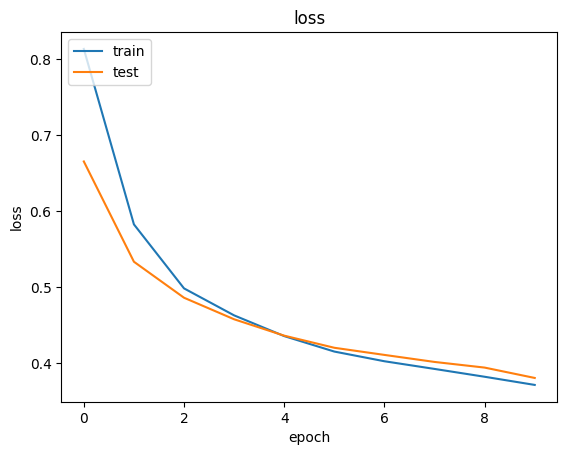

([0.8135282397270203,
  0.5826852917671204,
  0.49847617745399475,
  0.46297216415405273,
  0.43570587038993835,
  0.41536349058151245,
  0.4026184380054474,
  0.39251938462257385,
  0.3822208046913147,
  0.37147653102874756],
 [0.6654620170593262,
  0.5335392951965332,
  0.48618391156196594,
  0.45784005522727966,
  0.43627625703811646,
  0.42035049200057983,
  0.41095858812332153,
  0.40171340107917786,
  0.3942781388759613,
  0.38064613938331604],
 0.001,
 10,
 256)

In [19]:
train_model(
    conv_autoencoder, scaled_X_nomt_train, scaled_X_nomt_test, opt, epochs=10, bs=256
)


###################
Reconstruction Error of :
X_nomt_test
Mean
0.37679493
Median
0.24682906
Reconstruction Error of :
X_free
Mean
0.7393466
Median
0.7001207


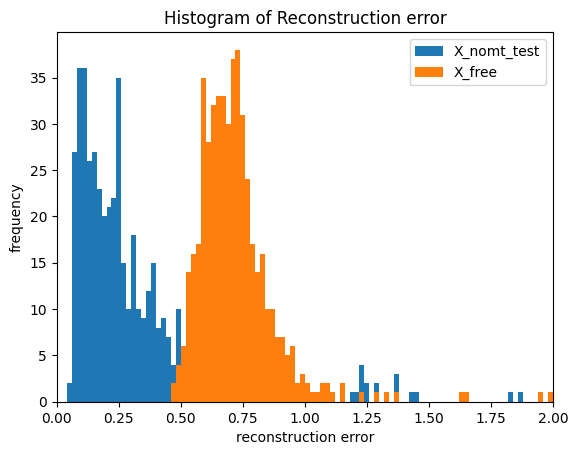

In [20]:
print_and_calc_results(
    conv_autoencoder,
    scaled_X_nomt_test[:500],
    "X_nomt_test",
    scaled_X_free[:500],
    "X_free",
)


In [21]:
acc_over_n_runs(conv_autoencoder, scaled_X_nomt_test, scaled_X_free, 0.4, 10)


###################
###################
###################
###################
###################
###################
###################
###################
###################
###################
[0.849, 0.867, 0.881, 0.852, 0.866, 0.866, 0.859, 0.87, 0.87, 0.861]
Final acc over 10 runs: 0.8641


In [22]:
# calc_accuracy(test_error, freeform_error, 1)


# Convolutional Autoencoder - Variants
## Increased encoding space

In [23]:
conv_autoencoder = ConvAutoencoder(encoding_dim=256)

opt = keras.optimizers.Adam(learning_rate=1e-3)
conv_autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


Epoch 1/10
20/20 [==============================] - 6s 212ms/step - loss: 0.7806 - val_loss: 0.5688
Epoch 2/10
20/20 [==============================] - 4s 192ms/step - loss: 0.5106 - val_loss: 0.4682
Epoch 3/10
20/20 [==============================] - 4s 191ms/step - loss: 0.4447 - val_loss: 0.4318
Epoch 4/10
20/20 [==============================] - 4s 193ms/step - loss: 0.4141 - val_loss: 0.4103
Epoch 5/10
20/20 [==============================] - 4s 196ms/step - loss: 0.3910 - val_loss: 0.3938
Epoch 6/10
20/20 [==============================] - 4s 198ms/step - loss: 0.3676 - val_loss: 0.3742
Epoch 7/10
20/20 [==============================] - 4s 198ms/step - loss: 0.3476 - val_loss: 0.3602
Epoch 8/10
20/20 [==============================] - 4s 209ms/step - loss: 0.3324 - val_loss: 0.3470
Epoch 9/10
20/20 [==============================] - 4s 204ms/step - loss: 0.3185 - val_loss: 0.3323
Epoch 10/10
20/20 [==============================] - 4s 191ms/step - loss: 0.3028 - val_loss: 0.3220

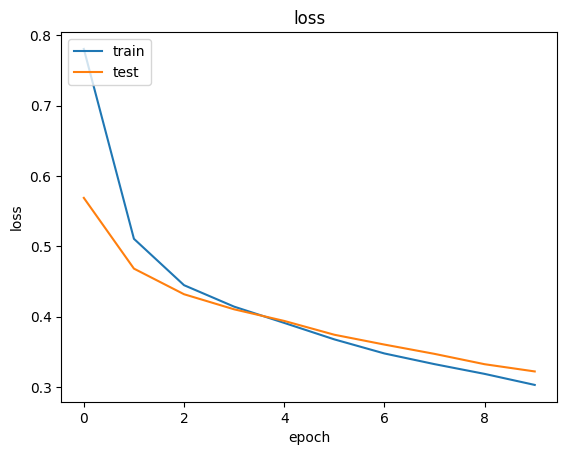

([0.7805840373039246,
  0.5105975866317749,
  0.4446594715118408,
  0.4141421318054199,
  0.39102426171302795,
  0.36760619282722473,
  0.34756505489349365,
  0.33239269256591797,
  0.3185243606567383,
  0.30284470319747925],
 [0.5687934160232544,
  0.46821820735931396,
  0.4317881166934967,
  0.41034188866615295,
  0.3938276469707489,
  0.37419283390045166,
  0.3602091372013092,
  0.34699341654777527,
  0.332285612821579,
  0.3220120072364807],
 0.001,
 10,
 256)

In [24]:
train_model(
    conv_autoencoder, scaled_X_nomt_train, scaled_X_nomt_test, opt, epochs=10, bs=256
)


###################
Reconstruction Error of :
X_nomt_test
Mean
0.31403485
Median
0.21806341
Reconstruction Error of :
X_free
Mean
0.6344425
Median
0.596506


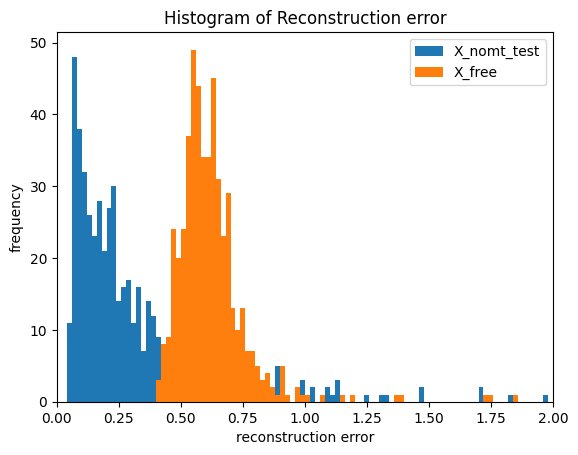

In [25]:
print_and_calc_results(
    conv_autoencoder,
    scaled_X_nomt_test[:500],
    "X_nomt_test",
    scaled_X_free[:500],
    "X_free",
)


In [26]:
acc_over_n_runs(conv_autoencoder, scaled_X_nomt_test, scaled_X_free, 0.4, 10)


###################
###################
###################
###################
###################
###################
###################
###################
###################
###################
[0.9, 0.88, 0.868, 0.898, 0.893, 0.902, 0.899, 0.896, 0.887, 0.888]
Final acc over 10 runs: 0.8911


## More layers

In [27]:
keras.backend.clear_session()
encoding_dim = 50


class ConvAutoencoder(Model):
    def __init__(self, encoding_dim):
        super(ConvAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.Input(
                    shape=(X_nomt_train.shape[1], X_nomt_train.shape[2])
                ),  # 401, 21
                layers.Conv1D(42, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.Conv1D(84, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.Conv1D(168, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.ZeroPadding1D(padding=((1,0))),
                layers.Flatten(),
                layers.Dense(encoding_dim, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(51 * 168, activation="relu", use_bias=False),
                layers.Reshape((51, 168)),
                layers.Conv1DTranspose(
                    168, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1DTranspose(
                    84, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1DTranspose(
                    42, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1D(
                    X_nomt_train.shape[2],
                    kernel_size=3,
                    activation=None,
                    padding="same",
                ),
                layers.Cropping1D(cropping=(6, 1)),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


conv_autoencoder = ConvAutoencoder(encoding_dim)


In [28]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
conv_autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


In [29]:
conv_autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 401, 42)           2688      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 401, 42)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 201, 42)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 201, 84)           10668     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 201, 84)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 101, 84)          0         
 1D)                                                    

In [30]:
# conv_autoencoder.decoder.summary()


Epoch 1/10
20/20 [==============================] - 7s 272ms/step - loss: 0.8508 - val_loss: 0.7162
Epoch 2/10
20/20 [==============================] - 5s 266ms/step - loss: 0.6067 - val_loss: 0.5412
Epoch 3/10
20/20 [==============================] - 5s 267ms/step - loss: 0.5002 - val_loss: 0.4805
Epoch 4/10
20/20 [==============================] - 5s 263ms/step - loss: 0.4555 - val_loss: 0.4473
Epoch 5/10
20/20 [==============================] - 5s 243ms/step - loss: 0.4301 - val_loss: 0.4340
Epoch 6/10
20/20 [==============================] - 5s 249ms/step - loss: 0.4124 - val_loss: 0.4174
Epoch 7/10
20/20 [==============================] - 5s 253ms/step - loss: 0.3984 - val_loss: 0.4077
Epoch 8/10
20/20 [==============================] - 5s 252ms/step - loss: 0.3869 - val_loss: 0.4034
Epoch 9/10
20/20 [==============================] - 5s 255ms/step - loss: 0.3763 - val_loss: 0.3967
Epoch 10/10
20/20 [==============================] - 5s 252ms/step - loss: 0.3678 - val_loss: 0.3802

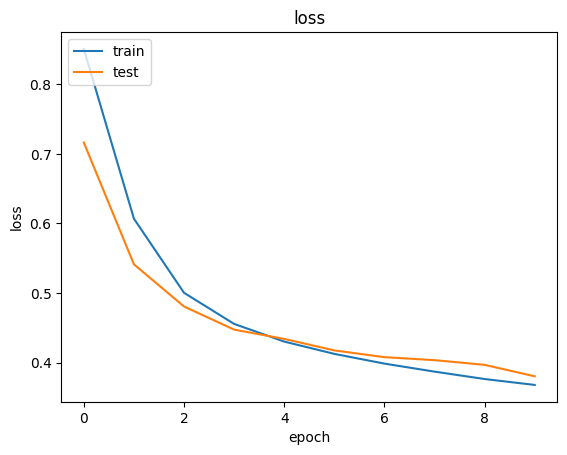

([0.8507981300354004,
  0.6067392230033875,
  0.500230073928833,
  0.455506831407547,
  0.4301053583621979,
  0.41242754459381104,
  0.3984360694885254,
  0.3869245946407318,
  0.3762796223163605,
  0.3678128123283386],
 [0.7161628603935242,
  0.5411674380302429,
  0.4805447459220886,
  0.4472959637641907,
  0.4339774250984192,
  0.4174167513847351,
  0.4077160954475403,
  0.40340787172317505,
  0.396673321723938,
  0.38020583987236023],
 0.001,
 10,
 256)

In [31]:
train_model(
    conv_autoencoder, scaled_X_nomt_train, scaled_X_nomt_test, opt, epochs=10, bs=256
)


###################
Reconstruction Error of :
X_nomt_test
Mean
0.37223226
Median
0.24696201
Reconstruction Error of :
X_free
Mean
0.74187994
Median
0.6986203


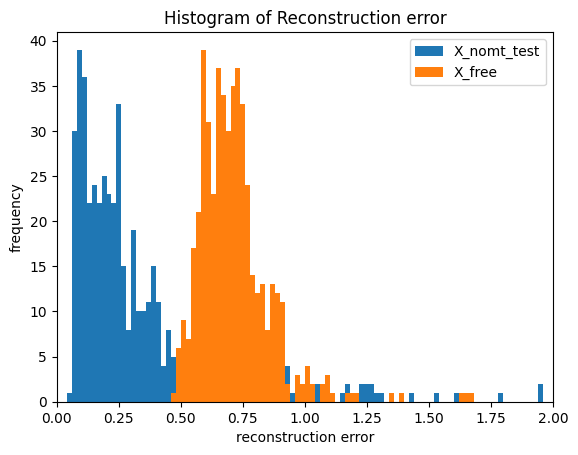

In [32]:
print_and_calc_results(
    conv_autoencoder,
    scaled_X_nomt_test[:500],
    "X_nomt_test",
    scaled_X_free[:500],
    "X_free",
)

In [33]:
acc_over_n_runs(conv_autoencoder, scaled_X_nomt_test, scaled_X_free, 0.4, 10)


###################
###################
###################
###################
###################
###################
###################
###################
###################
###################
[0.867, 0.861, 0.89, 0.864, 0.867, 0.867, 0.871, 0.859, 0.866, 0.866]
Final acc over 10 runs: 0.8677999999999999
